In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

In [2]:
#Read in data
RawData=pd.read_csv('.\RawDatafiles\RainShelterBeta_Energy.dat.gz', #specify file path for data to read in
                         compression = 'gzip',  #file is ziped
                         parse_dates=True, #tell the function to parse date columns to datetime formats
                         dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                         skiprows = [0,2,3], #leave out rows 1, 3 and 4 which have redundant information
                         index_col = 0, #Use the first column, which is Date, as an index
                         na_values = 'NAN')

## Check index for duplicates

In [3]:
seen = {}
dupes = []

for x in RawData.index:
    if x not in seen:
        seen[x] = 1
    else:
        if seen[x] == 1:
            dupes.append(x)
        seen[x] += 1
dupes

[Timestamp('2014-11-07 15:50:00'),
 Timestamp('2014-11-07 16:00:00'),
 Timestamp('2014-11-07 16:10:00'),
 Timestamp('2014-11-07 16:20:00'),
 Timestamp('2014-11-07 16:30:00'),
 Timestamp('2014-11-07 16:40:00')]

## These duplicates are where the loggers time was set from daylight savings to normal, need to subtract one hour from times in index prior to this change

In [4]:
RawData.index.size

32107

In [5]:
RawData.loc[:'2014-11-07 15:40:00'].index.size

675

In [6]:
IndexToFix = RawData.index.copy()

In [7]:
SectionToFix = IndexToFix[:675+6]

In [8]:
SectionToFix -= datetime.timedelta(hours=1) 

In [9]:
IndexValues = IndexToFix.get_values()
NewValues = SectionToFix.get_values()
IndexValues[:675+6] = NewValues

In [10]:
IndexValues

array(['2014-11-02T21:50:00.000000000', '2014-11-02T22:00:00.000000000',
       '2014-11-02T22:10:00.000000000', ...,
       '2015-02-25T06:45:00.000000000', '2015-02-25T06:50:00.000000000',
       '2015-02-25T06:55:00.000000000'], dtype='datetime64[ns]')

In [11]:
len(IndexValues)

32107

In [12]:
RawData.index = IndexValues

## Check again for duplicates

In [13]:
seen = {}
dupes = []

for x in RawData.index:
    if x not in seen:
        seen[x] = 1
    else:
        if seen[x] == 1:
            dupes.append(x)
        seen[x] += 1
dupes

[]

In [14]:
#Bring in index data
DataIndex=pd.read_csv('.\IndexFiles\RadiationAndTempIndex.csv',
                         index_col = 0)

#Apply indexes to data
DataTransposed = RawData[:-10].transpose() #Drop the last 10 rows because they are not from this trial
DataIndexed = pd.concat([DataIndex,DataTransposed], axis=1,sort=False)
DataIndexed.index.name='ColumnHeader'
DataIndexed.set_index(['Measurement','Cultivar','Irrigation','Treatment','Units','Summary','Plot','Block'], 
                         append=False, inplace=True)
Data=DataIndexed.transpose()
Data.index = pd.to_datetime(Data.index)  ## for some reason the concat function changes the data type on the date indes so need to change it back
Data = Data.drop(columns='Time',level=0) ## Drop blank time column
Data.sort_index(inplace=True)
Data.sort_index(axis=1,inplace=True)

### Work out how long our date series in in weeks

In [15]:
from datetime import timedelta #Import function needed for doing date deltas 
FirstMeasurement  = Data.index.min(axis=0)
LastMeasurement = Data.index.max(axis=0)
Duration = (LastMeasurement - FirstMeasurement)/timedelta(weeks=1)
ExptDuration = np.round(Duration,decimals=0) #weeks
ExptDuration

16.0

In [16]:
ColorIndex = pd.DataFrame(index = ['High','Mid','Low'],columns=['Col'],data=['b','g','r'])

### Graph data in two weekly blocks to see how it looks

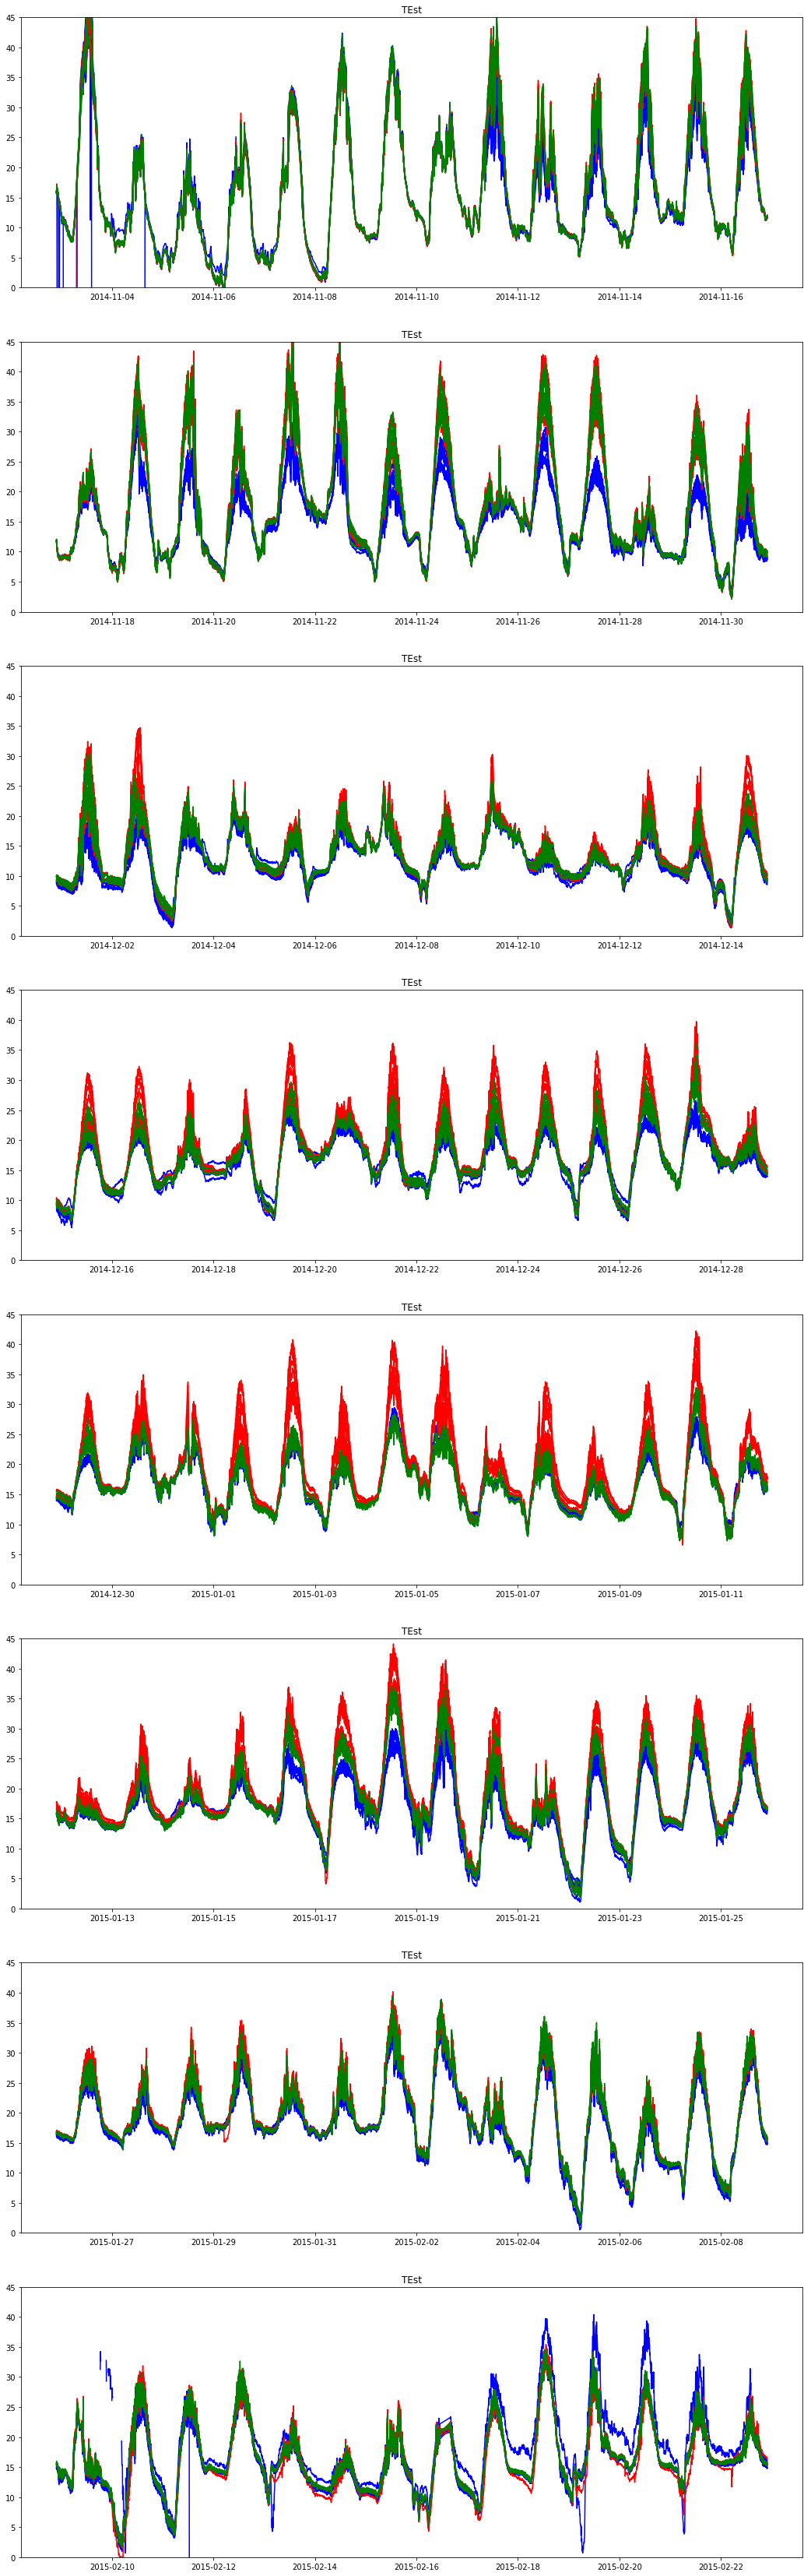

In [17]:
#Create a figure object
Fig = plt.figure(figsize=(18, 60))

cycle=[ColorIndex.loc[x,'Col'] for x in Data.IR_SurfaceTemp.columns.get_level_values(1)]
#Function call to populate figure with subplots
def MakePlot(Pannels, Position, StartDate, EndDate):
    ax = Fig.add_subplot(Pannels,1,Position)
    ax.set_prop_cycle(color=cycle)
    plt.title('TEst', fontsize=12);
    plt.plot(Data.IR_SurfaceTemp.loc[StartDate:EndDate,:].index,Data.IR_SurfaceTemp.loc[StartDate:EndDate,:]);
   
    plt.ylim(0,45)
    return;

PlotDuration = 2
Pannels = np.int(ExptDuration/PlotDuration)

for X in range (0,Pannels):
    if (X == 0):
        StartDate = Data.index.min(axis=0)  #Set start of series at start of data
    else: 
        StartDate = StartDate + timedelta(weeks=PlotDuration)    #increment start date by a week
    StartDateString = StartDate.strftime("%Y-%m-%d")  #Turn this to a string
    EndDate = StartDate + timedelta(weeks=PlotDuration)       #Set start date the specified duration before the end date 
    EndDateString = EndDate.strftime("%Y-%m-%d")           #Turn that into a string
    Position = X+1;
    MakePlot(Pannels, Position,StartDate,EndDate)

### Some of the sensors in full irrig treatment appear to go wonky at the start and end.  Lets work out which sensors

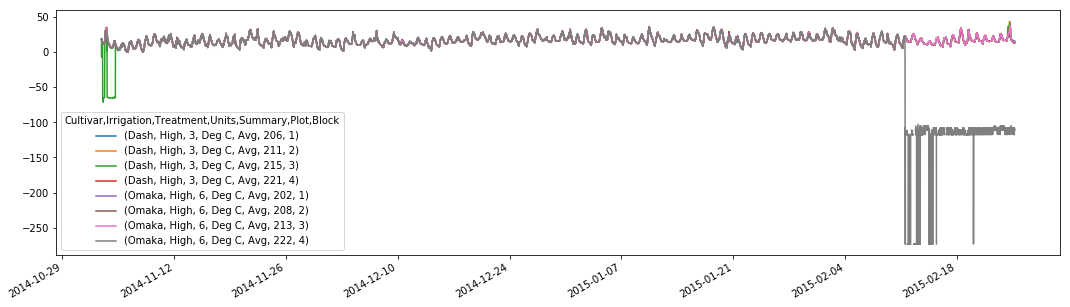

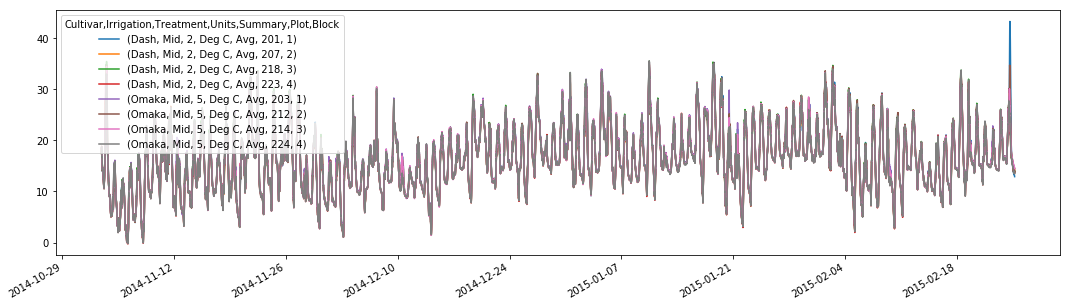

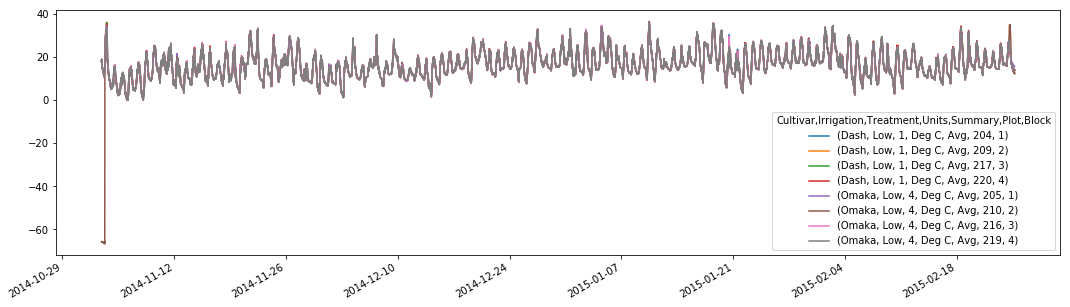

In [18]:
Data.IR_SensorBodyTemp.loc[:, Data.IR_SensorBodyTemp.columns.isin(['High'],level=1)].plot(figsize=(18,5))
Data.IR_SensorBodyTemp.loc[:, Data.IR_SensorBodyTemp.columns.isin(['Mid'],level=1)].plot(figsize=(18,5))
Data.IR_SensorBodyTemp.loc[:, Data.IR_SensorBodyTemp.columns.isin(['Low'],level=1)].plot(figsize=(18,5))

### There is a problem with one sensor.  Drop the canopy temp data from this sensor when the ref temp is errant

In [19]:
Data.IR_SurfaceTemp =  Data.IR_SurfaceTemp.where(Data.IR_SensorBodyTemp>0,np.nan) 
Data.IR_SensorBodyTemp =  Data.IR_SensorBodyTemp.where(Data.IR_SensorBodyTemp>0,np.nan) 

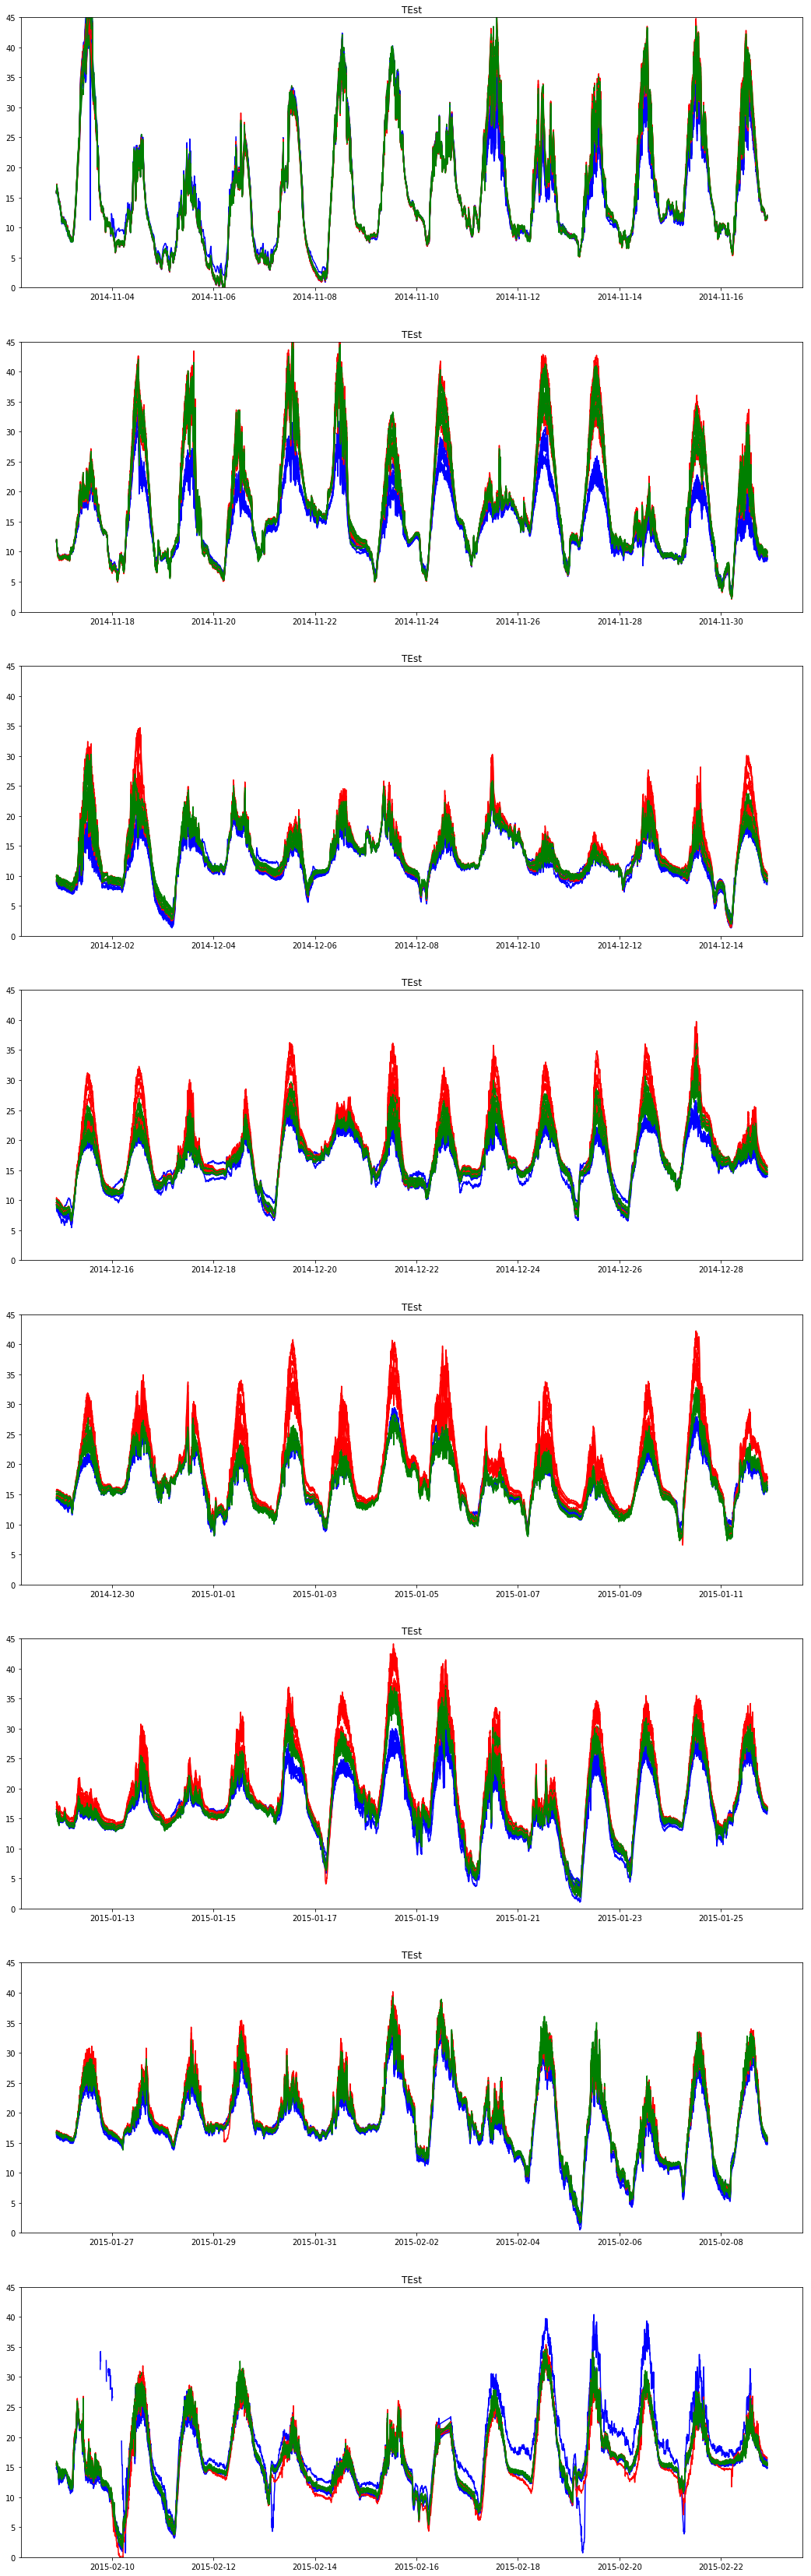

In [20]:
#Create a figure object
Fig = plt.figure(figsize=(18, 60))

cycle=[ColorIndex.loc[x,'Col'] for x in Data.IR_SurfaceTemp.columns.get_level_values(1)]
#Function call to populate figure with subplots
def MakePlot(Pannels, Position, StartDate, EndDate):
    ax = Fig.add_subplot(Pannels,1,Position)
    ax.set_prop_cycle(color=cycle)
    plt.title('TEst', fontsize=12);
    plt.plot(Data.IR_SurfaceTemp.loc[StartDate:EndDate,:].index,Data.IR_SurfaceTemp.loc[StartDate:EndDate,:]);
    plt.ylim(0,45)
    return;

PlotDuration = 2
Pannels = np.int(ExptDuration/PlotDuration)

for X in range (0,Pannels):
    if (X == 0):
        StartDate = Data.index.min(axis=0)  #Set start of series at start of data
    else: 
        StartDate = StartDate + timedelta(weeks=PlotDuration)    #increment start date by a week
    StartDateString = StartDate.strftime("%Y-%m-%d")  #Turn this to a string
    EndDate = StartDate + timedelta(weeks=PlotDuration)       #Set start date the specified duration before the end date 
    EndDateString = EndDate.strftime("%Y-%m-%d")           #Turn that into a string
    Position = X+1;
    MakePlot(Pannels, Position,StartDate,EndDate)

### There is still a problem with one sensor.  Lets look at reference temperature again.


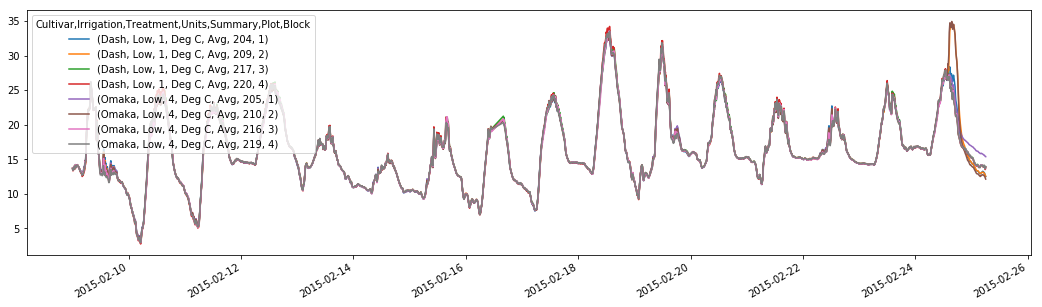

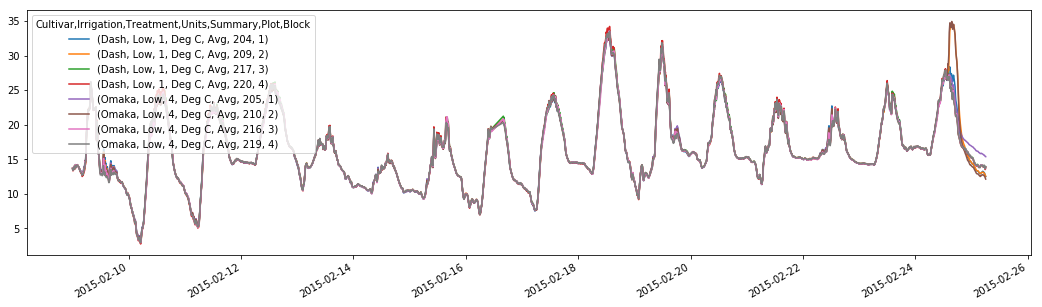

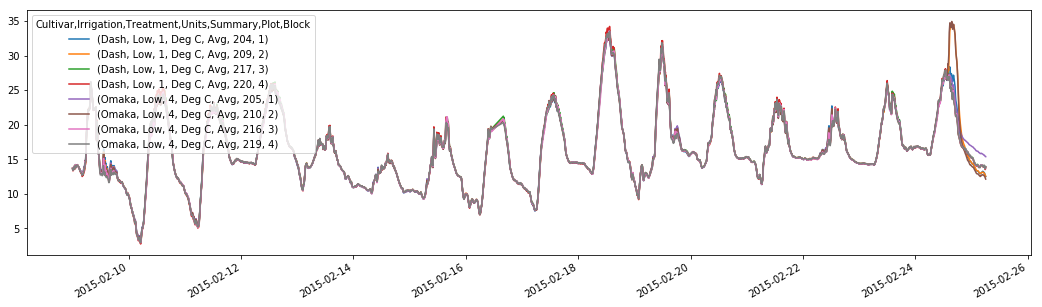

In [21]:
#HourlyRefTemp.where(HourlyRefTemp>0,np.nan,inplace=True)
Data.IR_SensorBodyTemp.loc['2015-02-09':,Data.IR_SensorBodyTemp.columns.isin(['Low'], level=1)].plot(figsize=(18,5))
Data.IR_SensorBodyTemp.loc['2015-02-09':,Data.IR_SensorBodyTemp.columns.isin(['Low'], level=1)].plot(figsize=(18,5))
Data.IR_SensorBodyTemp.loc['2015-02-09':,Data.IR_SensorBodyTemp.columns.isin(['Low'], level=1)].plot(figsize=(18,5))

### Ref temperatures all look OK.  Look at canopy temp again to see which is problematic

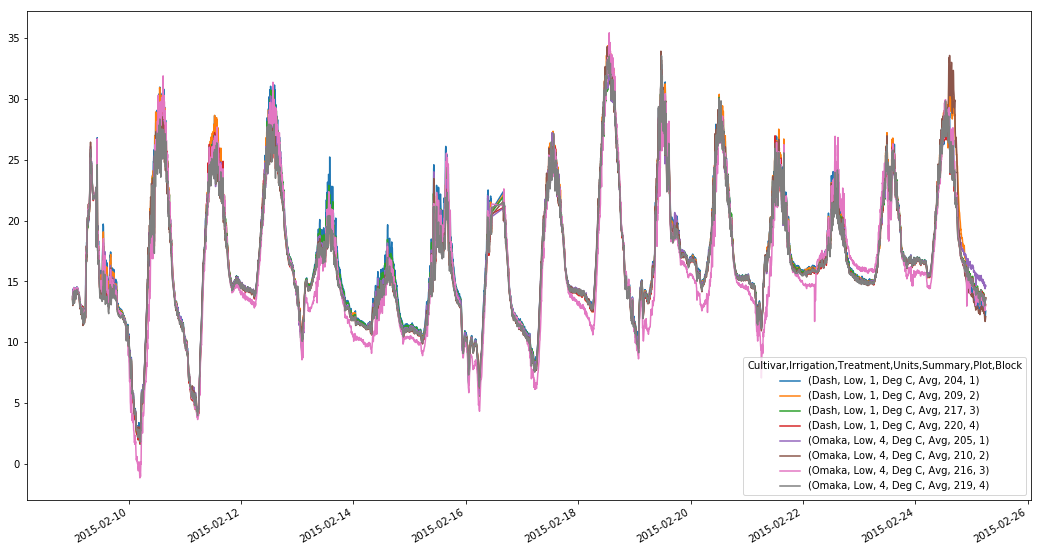

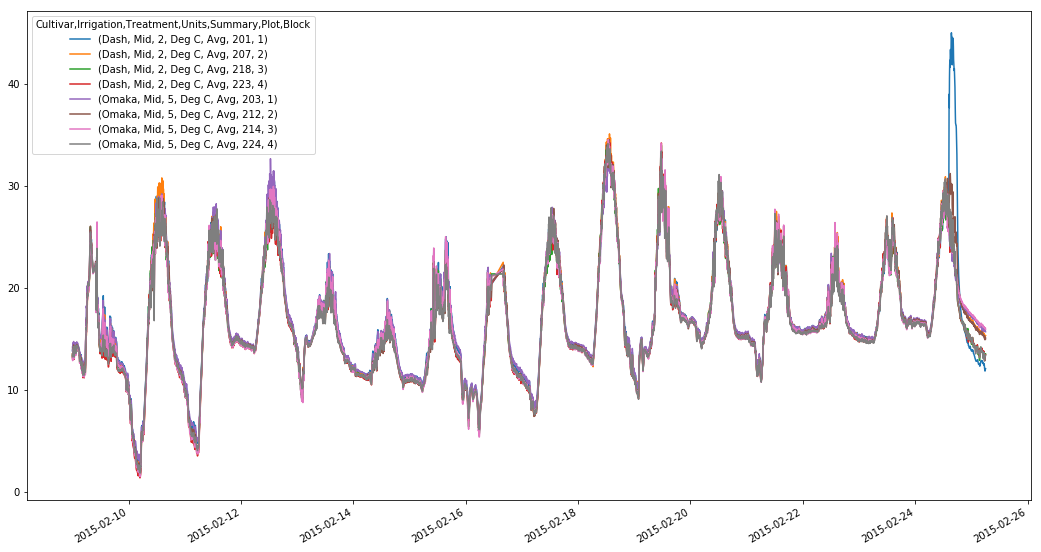

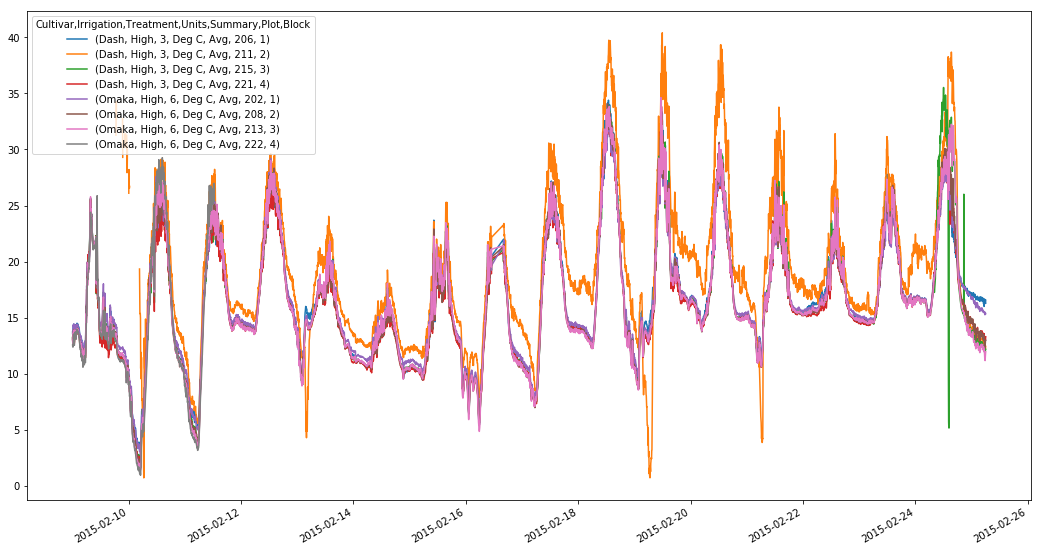

In [22]:
Data.IR_SurfaceTemp.loc['2015-02-09':,Data.IR_SurfaceTemp.columns.isin(['Low'], level = 1)].plot(figsize=(18,10))
Data.IR_SurfaceTemp.loc['2015-02-09':,Data.IR_SurfaceTemp.columns.isin(['Mid'], level = 1)].plot(figsize=(18,10))
Data.IR_SurfaceTemp.loc['2015-02-09':,Data.IR_SurfaceTemp.columns.isin(['High'], level = 1)].plot(figsize=(18,10))

### The sensor on plot 211 started playing up for some reason after the 9th of February.  Lets remove the data for that sensor over that period

In [23]:
Data.loc['2015-02-09':,('IR_SurfaceTemp','Dash','High','3','Deg C', 'Avg','211')] = np.nan

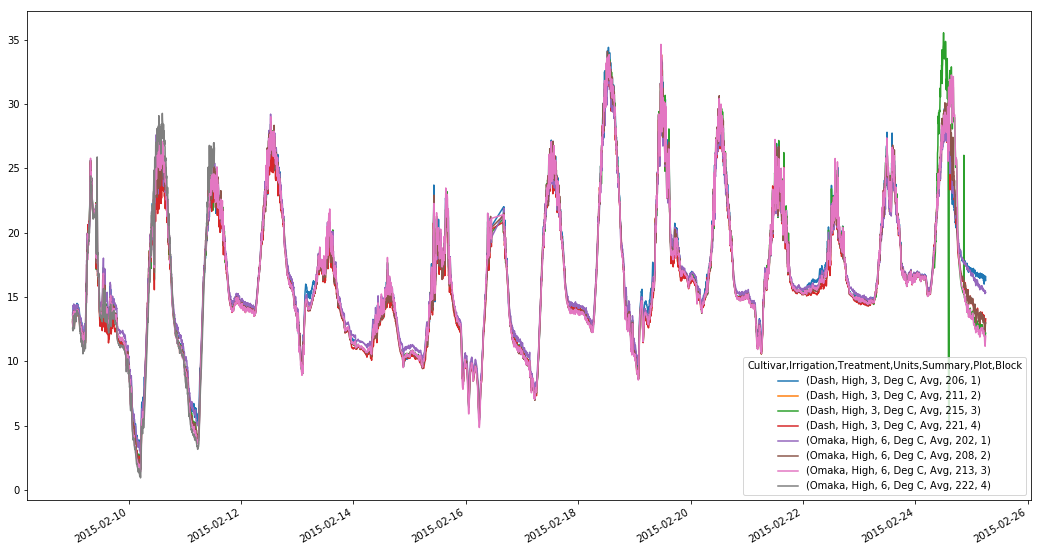

In [24]:
Data.IR_SurfaceTemp.loc['2015-02-09':,Data.IR_SurfaceTemp.columns.isin(['High'],level=1)].plot(figsize=(18,10))

# Now lets look at soil temp

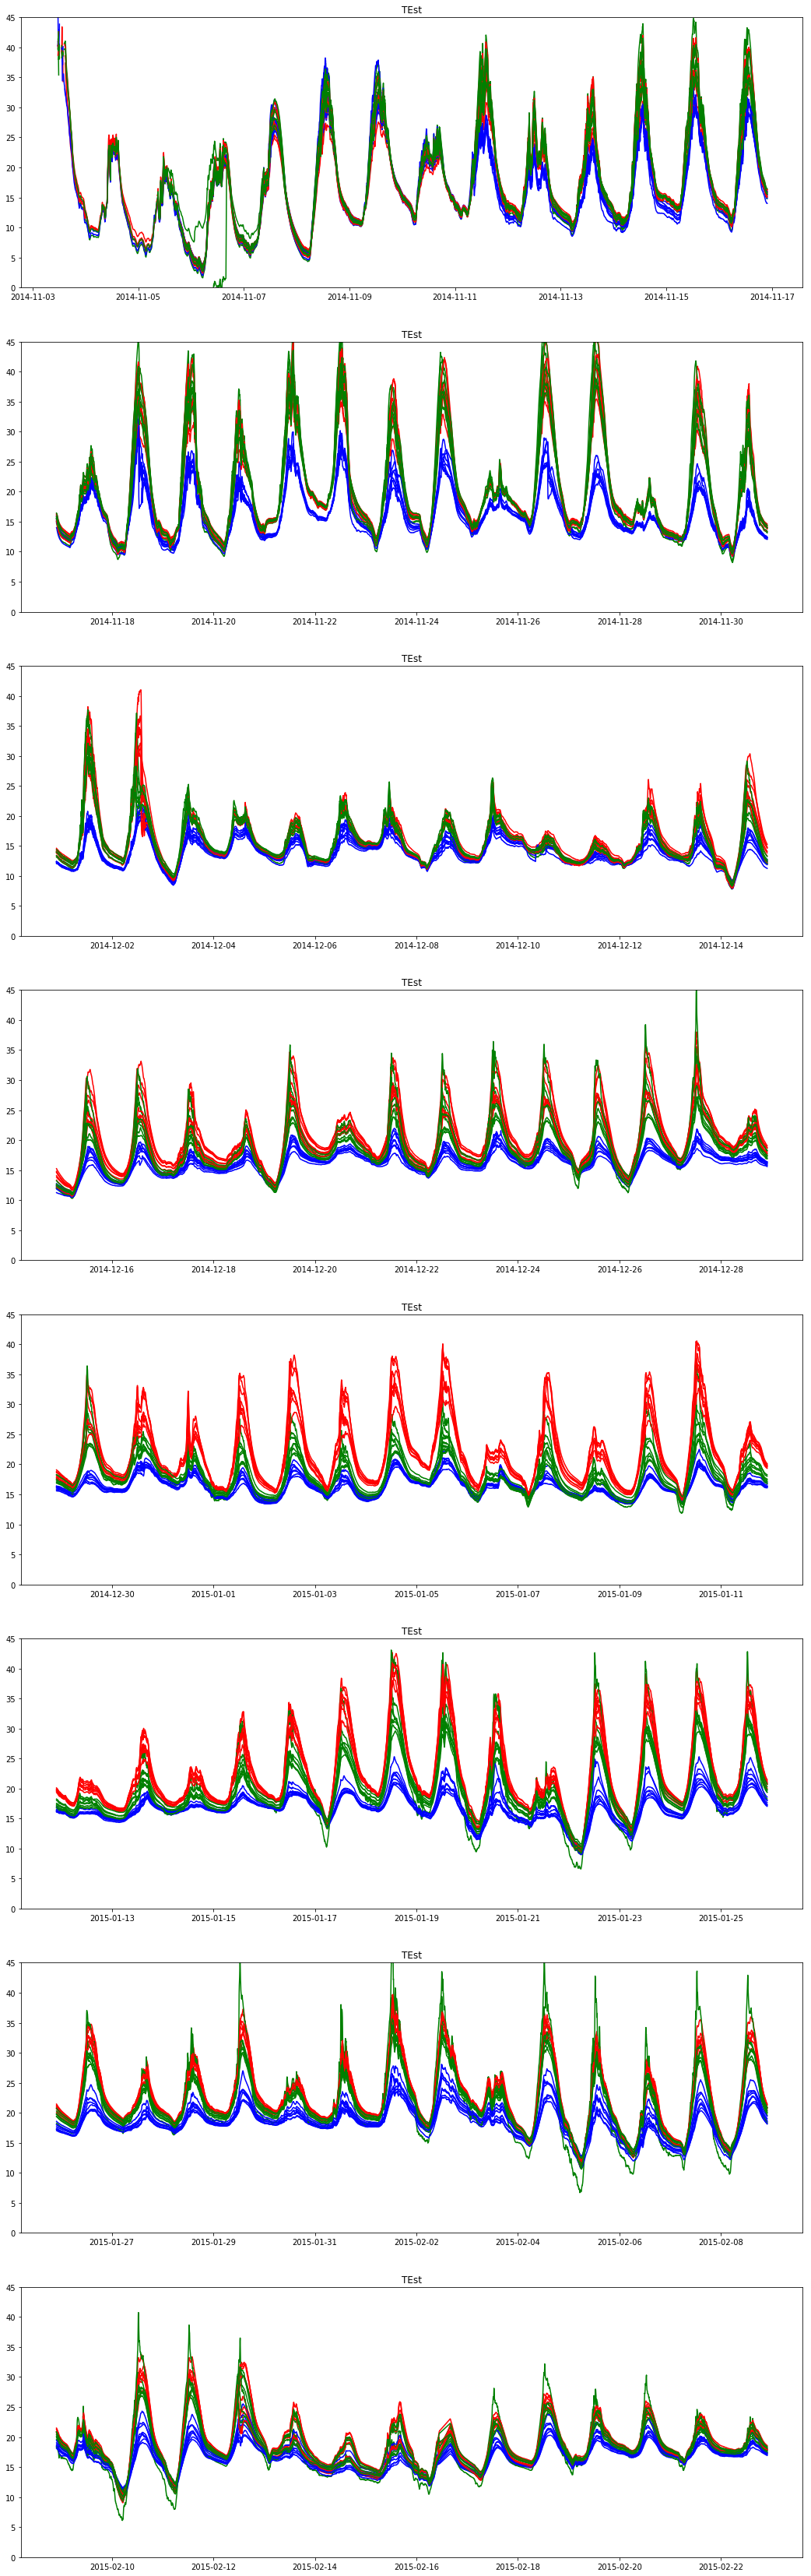

In [25]:
#Create a figure object
Fig = plt.figure(figsize=(18, 60))

cycle=[ColorIndex.loc[x,'Col'] for x in Data.SurfaceSoilTemp.columns.get_level_values(1)]

#Function call to populate figure with subplots
def MakePlot(Pannels, Position, StartDate, EndDate):
    ax = Fig.add_subplot(Pannels,1,Position)
    ax.set_prop_cycle(color=cycle)
    plt.title('TEst', fontsize=12);
    plt.plot(Data.SurfaceSoilTemp.loc[StartDate:EndDate,:].index,Data.SurfaceSoilTemp.loc[StartDate:EndDate,:]);
    plt.ylim(0,45)
    return;

PlotDuration = 2
Pannels = np.int(ExptDuration/PlotDuration)

for X in range (0,Pannels):
    if (X == 0):
        StartDate = Data.index.min(axis=0)  #Set start of series at start of data
    else: 
        StartDate = StartDate + timedelta(weeks=PlotDuration)    #increment start date by a week
    StartDateString = StartDate.strftime("%Y-%m-%d")  #Turn this to a string
    EndDate = StartDate + timedelta(weeks=PlotDuration)       #Set start date the specified duration before the end date 
    EndDateString = EndDate.strftime("%Y-%m-%d")           #Turn that into a string
    Position = X+1;
    MakePlot(Pannels, Position,StartDate,EndDate)

## No obvious outlyers, assume needs no cleaning

# Check Met Data.  Radiation first.

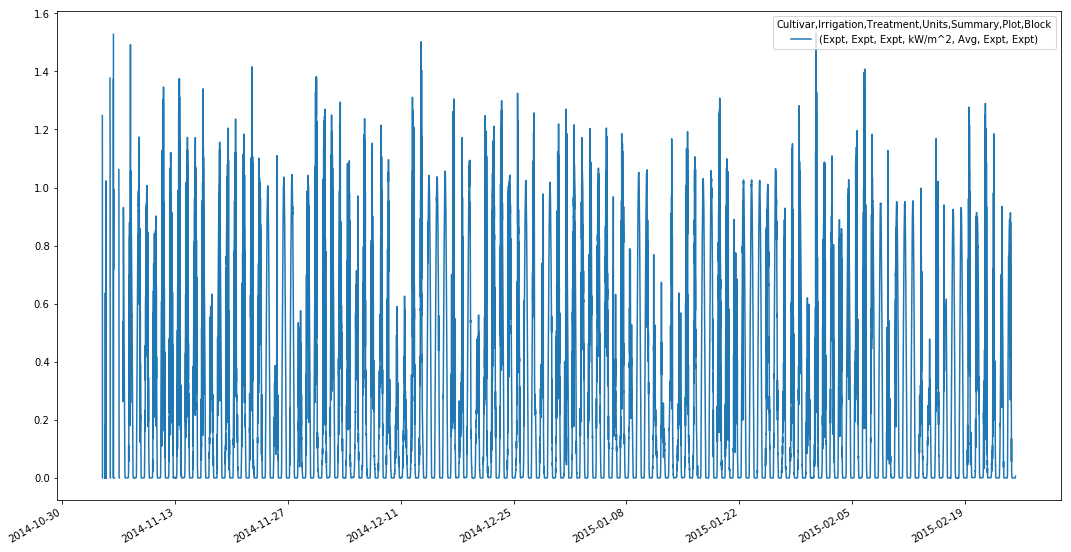

In [26]:
Data.IncomingRadnKW.plot(figsize = (18,10))

## Then Air Temperature

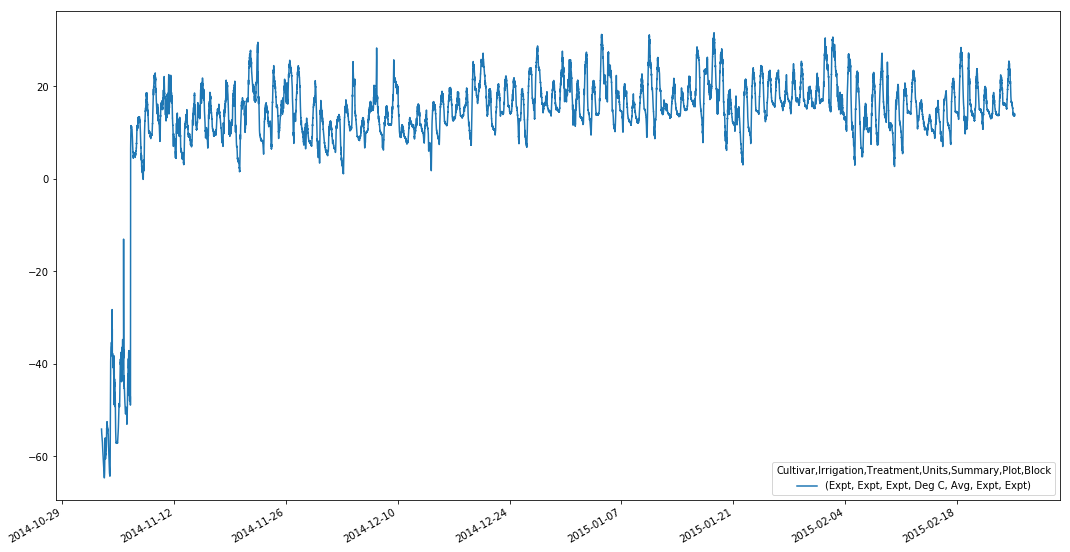

In [27]:
Data.AirTemperature.plot(figsize = (18,10))

## Sensor problem before the 7th of November so we will remove that data

In [28]:
Data.loc[:'2014-11-7','AirTemperature'] = np.nan

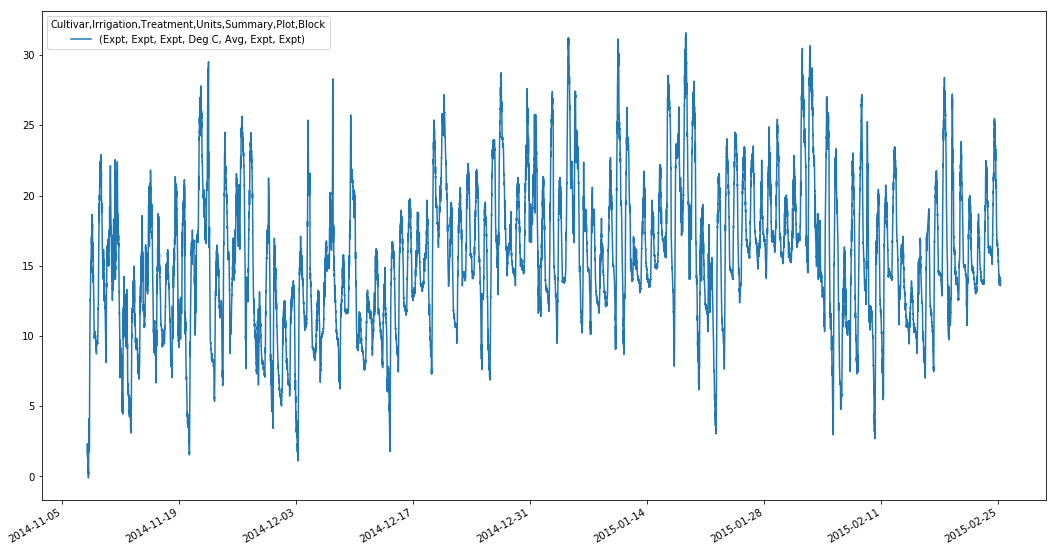

In [29]:
Data.AirTemperature.plot(figsize = (18,10))

## Check humidity

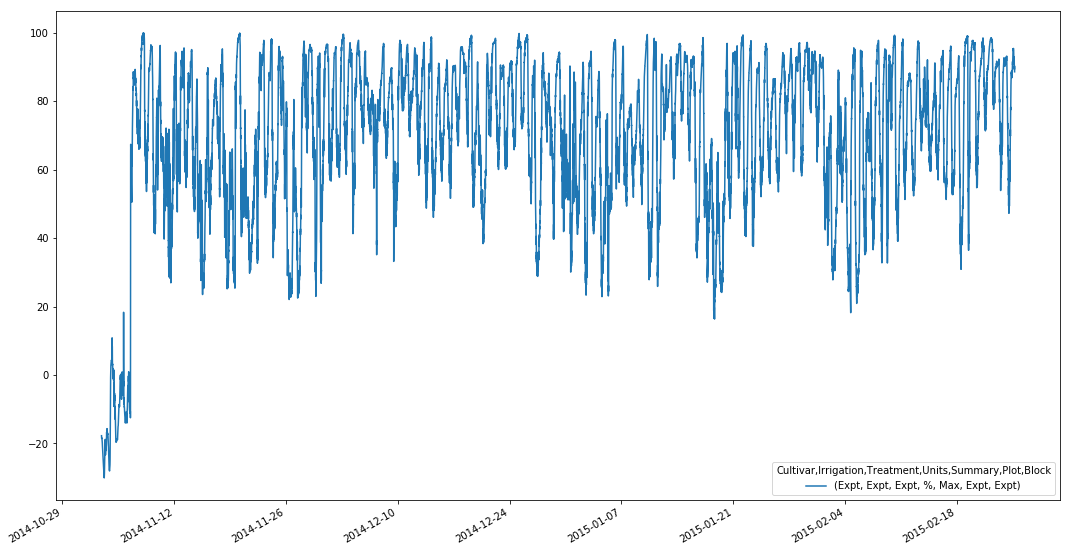

In [30]:
Data.RelativeHumidity.plot(figsize = (18,10))

## Sensor problem before the 7th of November so we will remove that data

In [31]:
Data.loc[:'2014-11-7','RelativeHumidity'] = np.nan

## Check Wind

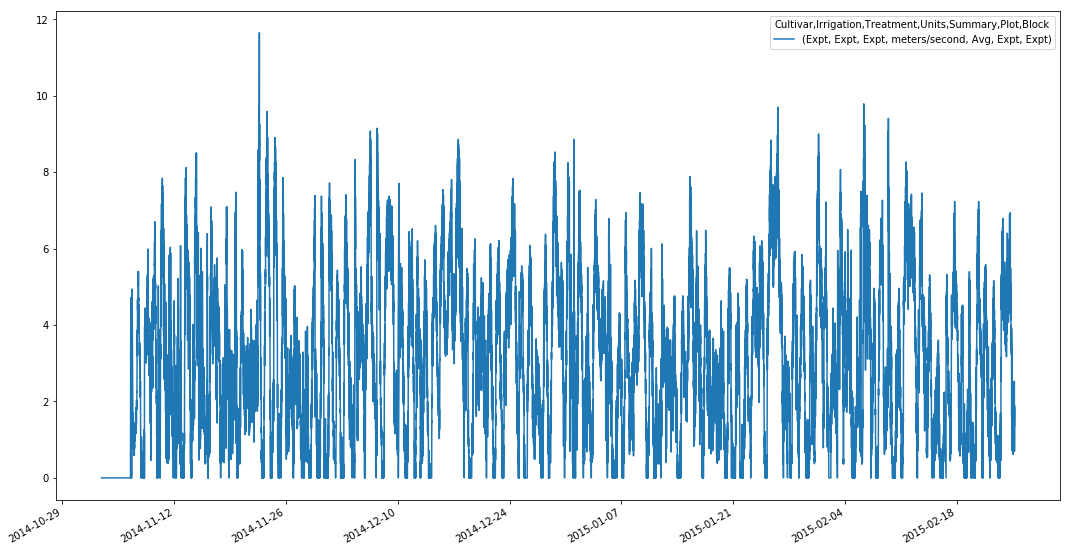

In [32]:
Data.Windspeed.plot(figsize = (18,10))

## Check Leaf Wettness

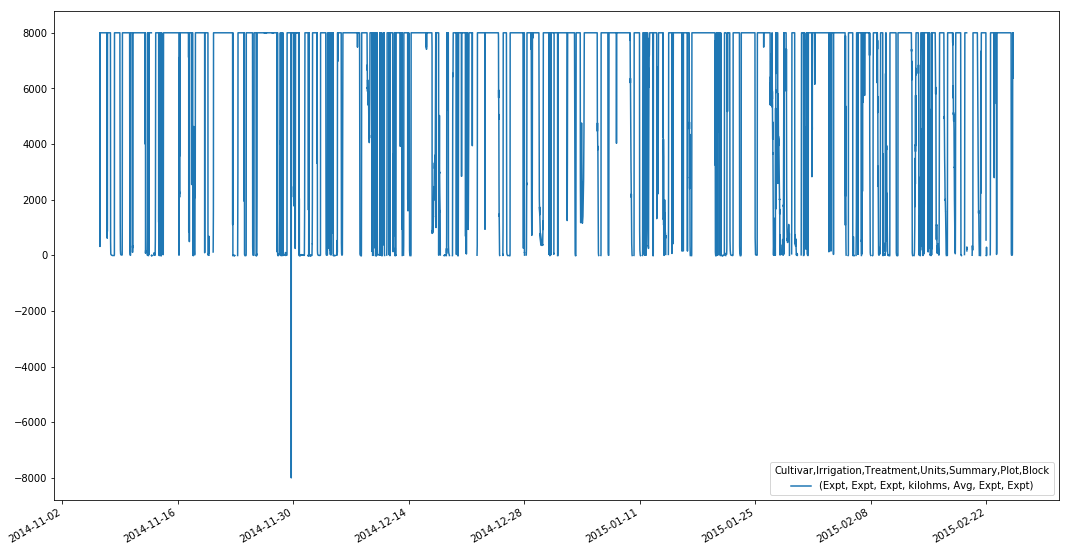

In [33]:
Data.Leafwetness.plot(figsize = (18,10))

## Now lets look at above canopy par

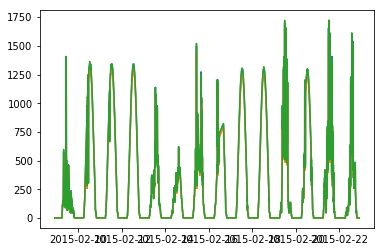

In [34]:
plt.plot(Data.AboveCanopyPAR1.loc[StartDate:EndDate,:])
plt.plot(Data.AboveCanopyPAR2.loc[StartDate:EndDate,:])
plt.plot(Data.AboveCanopyPAR3.loc[StartDate:EndDate,:])

## all three are behaving well so lets take the mean

In [35]:
Data.loc[:,('AboveCanopyPAR','Expt','Expt','Expt','mmolPAR','Ave','Expt','Expt')] = Data.loc[:,['AboveCanopyPAR1','AboveCanopyPAR2','AboveCanopyPAR3']].mean(axis=1)

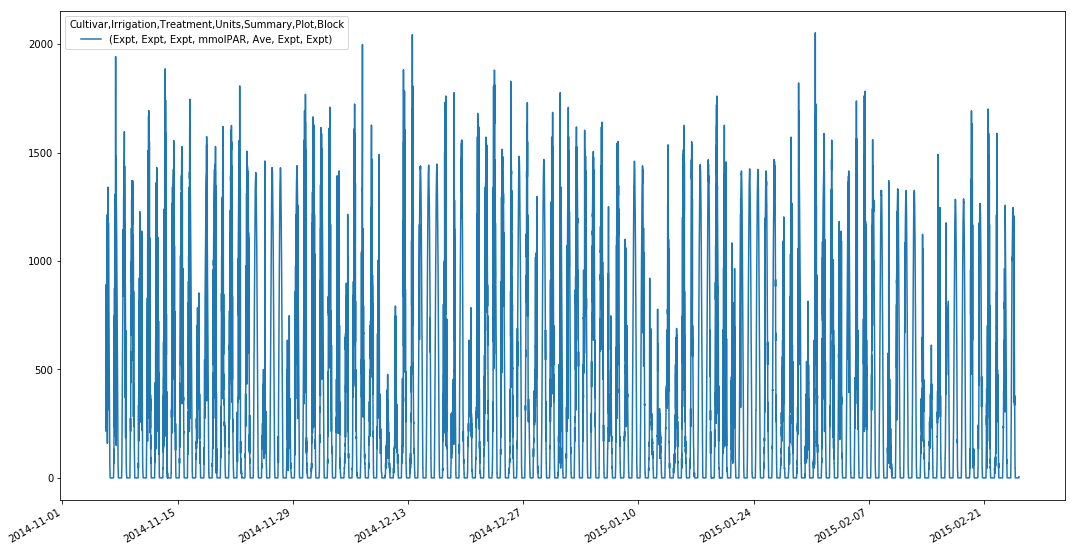

In [36]:
Data.AboveCanopyPAR.plot(figsize = (18,10))

In [37]:
Data.drop(columns = ['AboveCanopyPAR1','AboveCanopyPAR2','AboveCanopyPAR3'], level=0,inplace=True)

# Now we have a clean data set lets pickle it

In [38]:
Data.to_pickle('.\DataFrames\TempAndRadnCleaned.pkl')

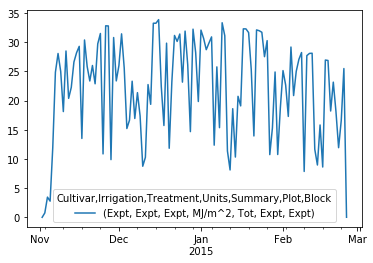

In [39]:
Data.IncomingRadnMJ.resample('d').sum().plot()

In [40]:
Data

Measurement         AirTemperature BatteryVoltage BelowCanopyPAR            \
Cultivar                      Expt           Expt           Dash             
Irrigation                    Expt           Expt           High             
Treatment                     Expt           Expt              3             
Units                        Deg C          Volts        mmolPAR             
Summary                        Avg            Avg            Avg             
Plot                          Expt           Expt            206  215  221   
Block                         Expt           Expt              1    3    4   
2014-11-02 21:50:00            NaN          12.88            NaN  NaN  NaN   
2014-11-02 22:00:00            NaN          12.88            NaN  NaN  NaN   
2014-11-02 22:10:00            NaN          12.88            NaN  NaN  NaN   
2014-11-02 22:20:00            NaN          12.88            NaN  NaN  NaN   
2014-11-02 22:30:00            NaN          12.88            NaN  NaN  NaN   
2014-11-02 22:40:00            NaN          12.85            NaN  NaN  NaN   
2014-11-02 22:50:00            NaN          12.86            NaN  NaN  NaN   
2014-11-02 23:00:00            NaN          12.79            NaN  NaN  NaN   
2014-11-02 23:10:00            NaN          12.85            NaN  NaN  NaN   
2014-11-02 23:20:00            NaN          12.84            NaN  NaN  NaN   
2014-11-02 23:30:00            NaN          12.84            NaN  NaN  NaN   
2014-11-02 23:40:00            NaN          12.82            NaN  NaN  NaN   
2014-11-02 23:50:00            NaN          12.76            NaN  NaN  NaN   
2014-11-03 00:00:00            NaN          12.81            NaN  NaN  NaN   
2014-11-03 00:10:00            NaN          12.81            NaN  NaN  NaN   
2014-11-03 00:20:00            NaN          12.80            NaN  NaN  NaN   
2014-11-03 00:30:00            NaN          12.80            NaN  NaN  NaN   
2014-11-03 00:40:00            NaN          12.79            NaN  NaN  NaN   
2014-11-03 00:50:00            NaN          12.80            NaN  NaN  NaN   
2014-11-03 01:00:00            NaN          12.79            NaN  NaN  NaN   
2014-11-03 01:10:00            NaN          12.80            NaN  NaN  NaN   
2014-11-03 01:20:00            NaN          12.80            NaN  NaN  NaN   
2014-11-03 01:30:00            NaN          12.78            NaN  NaN  NaN   
2014-11-03 01:40:00            NaN          12.78            NaN  NaN  NaN   
2014-11-03 01:50:00            NaN          12.79            NaN  NaN  NaN   
2014-11-03 02:00:00            NaN          12.78            NaN  NaN  NaN   
2014-11-03 02:10:00            NaN          12.79            NaN  NaN  NaN   
2014-11-03 02:20:00            NaN          12.79            NaN  NaN  NaN   
2014-11-03 02:30:00            NaN          12.79            NaN  NaN  NaN   
2014-11-03 02:40:00            NaN          12.79            NaN  NaN  NaN   
...                            ...            ...            ...  ...  ...   
2015-02-25 03:40:00          13.82          12.87            0.0  0.0  0.0   
2015-02-25 03:45:00          14.19          12.88            0.0  0.0  0.0   
2015-02-25 03:50:00          14.22          12.83            0.0  0.0  0.0   
2015-02-25 03:55:00          14.12          12.87            0.0  0.0  0.0   
2015-02-25 04:00:00          14.12          12.88            0.0  0.0  0.0   
2015-02-25 04:05:00          13.99          12.81            0.0  0.0  0.0   
2015-02-25 04:10:00          14.02          12.85            0.0  0.0  0.0   
2015-02-25 04:15:00          13.95          12.87            0.0  0.0  0.0   
2015-02-25 04:20:00          13.95          12.82            0.0  0.0  0.0   
2015-02-25 04:25:00          13.95          12.85            0.0  0.0  0.0   
2015-02-25 04:30:00          13.85          12.87            0.0  0.0  0.0   
2015-02-25 04:35:00          13.92          12.80            0.0  0.0  0.0   
2015-02-25 04:40:00   